In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ..report_config import ReportConfig
from ..utils import (
    get_good_rating_companies,
    get_bad_rating_companies,
    get_neutral_rating_companies,
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
MIN_REVIEWS = 42 / 2  # (reviews median) / 2

In [ ]:
reviews_df = pd.read_csv("../glassdoor_reviews_predicted.csv")

### Create sentiment plot

In [4]:
sentiment_mapping = {0: 3, 1: 1, 2: 2}
reviews_df["sentiment_plot"] = reviews_df["sentiment"].map(
    sentiment_mapping
)

### Get ranking of positive and negative companies

In [5]:
reviews_df["sentiment_plot"] = np.select(
    condlist=[
        (reviews_df["sentiment"] == 0),
        (reviews_df["sentiment"] == 1),
        (reviews_df["sentiment"] == 2),
    ],
    choicelist=[3, 1, 2],
)

reviews_count_df = reviews_df.groupby(["company"])["review_text"].count()

reviews_count_df = reviews_count_df.reset_index()
reviews_count_df.columns = [
    "company",
    "reviews_count",
]

reviews_df = pd.merge(
    left=reviews_df,
    right=reviews_count_df,
    on="company",
    how="left",
)

sentiment_plot_by_company_df = (
    reviews_df.groupby(["company", "sentiment_plot"])["review_text"]
    .count()
    .unstack(fill_value=0)
)

sentiment_plot_by_company_df = sentiment_plot_by_company_df.reset_index()

sentiment_plot_by_company_df.columns = [
    "company",
    "1positive",
    "2negative",
    "3neutral",
]

sentiment_plot_by_company_df["sentiment_diff"] = (
    sentiment_plot_by_company_df["1positive"]
    - sentiment_plot_by_company_df["2negative"]
)

sentiment_plot_by_company_df = sentiment_plot_by_company_df.sort_values(
    by="sentiment_diff", ascending=False
).reset_index()

sentiment_plot_by_company_df = sentiment_plot_by_company_df.drop(labels="index", axis=1)

bad_rating_companies = get_bad_rating_companies(sentiment_plot_by_company_df)

good_rating_companies = get_good_rating_companies(sentiment_plot_by_company_df)

reviews_30_plus_df = pd.merge(
    left=reviews_df,
    right=sentiment_plot_by_company_df,
    on="company",
    how="left",
)

reviews_30_plus_df = reviews_30_plus_df.sort_values(
    by="sentiment_diff", ascending=False
).reset_index()

reviews_30_plus_df = reviews_30_plus_df[
    reviews_30_plus_df["reviews_count"] >= MIN_REVIEWS
]

reviews_30_plus_df["sentiment_count"] = np.select(
    condlist=[
        (reviews_30_plus_df["sentiment_plot"] == 1),  # Positive
        (reviews_30_plus_df["sentiment_plot"] == 2),  # Negative
        (reviews_30_plus_df["sentiment_plot"] == 3),  # Neutral
    ],
    choicelist=[
        reviews_30_plus_df["1positive"],
        reviews_30_plus_df["2negative"],
        reviews_30_plus_df["3neutral"],
    ],
    default=0,
)

top_good_bad_companies_by_sentiment_diff = reviews_30_plus_df[
    (
        reviews_30_plus_df["company"].isin(good_rating_companies[:5])
        | reviews_30_plus_df["company"].isin(bad_rating_companies[:5])
    )
]

top_positive_companies_df = top_good_bad_companies_by_sentiment_diff[
    top_good_bad_companies_by_sentiment_diff["sentiment_diff"] > 0
]

top_positive_companies_df = top_positive_companies_df.sort_values(
    by=["sentiment_diff", "reviews_count"],
    ascending=False,
).reset_index()

top_negative_companies_df = top_good_bad_companies_by_sentiment_diff[
    top_good_bad_companies_by_sentiment_diff["sentiment_diff"] < 0
]

top_negative_companies_df = top_negative_companies_df.sort_values(
    by=["sentiment_diff", "reviews_count"],
    ascending=True,
).reset_index()

## Ranking de avaliações positivas por empresa

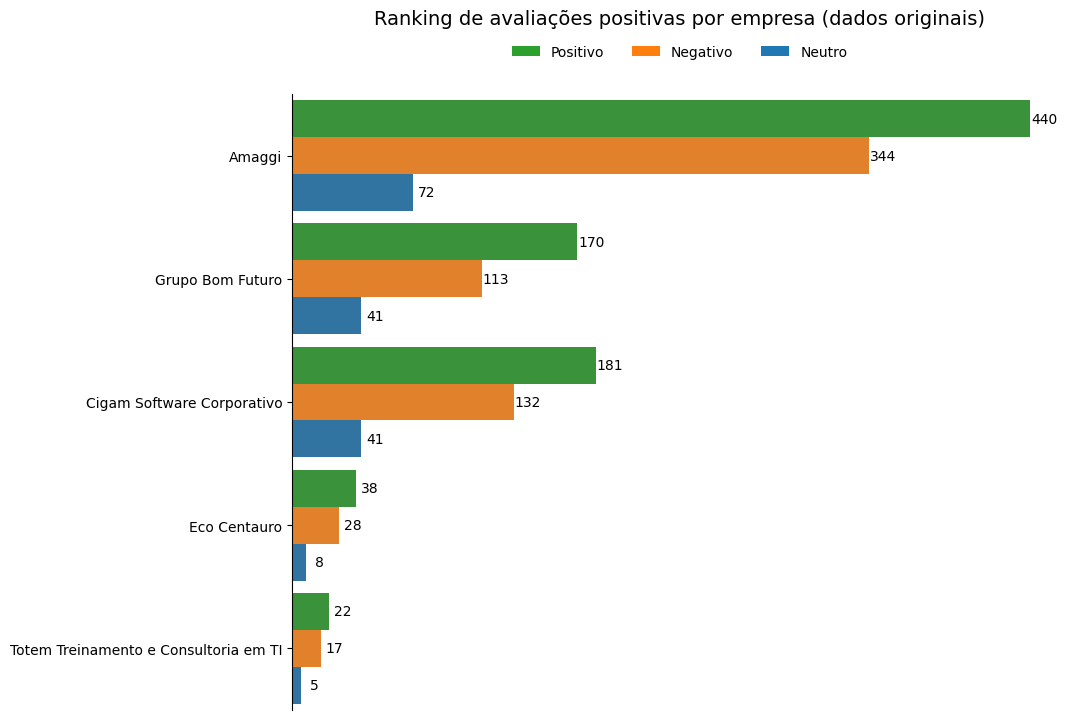

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 8))

sns.barplot(
    data=top_positive_companies_df,
    x="sentiment_count",
    y="company",
    hue="sentiment_plot",
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax,
    width=0.9,
    orient="h",
)

# Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width(), (p.get_y() + p.get_height() / 2)),
        ha="center",
        va="center",
        fontsize=10,
        color="black",
        xytext=(10, 0),
        textcoords="offset points",
    )

# Axes config
ax.set_xlabel("")

ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Ranking de avaliações positivas por empresa (dados originais)",
    fontsize=ReportConfig.CHART_TITLE_FONT_SIZE,
    y=1.1,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

positive_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR)
negative_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR)
neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

ax.legend(
    # title="Sentimento",
    handles=[positive_patch, negative_patch, neutral_patch],
    labels=ReportConfig.PLOT_SENTIMENT_LABELS,
    bbox_to_anchor=(0.5, 1.1),
    loc="upper center",
    edgecolor="1",
    ncols=3,
)

plt.savefig(
    "real_positive_reviews_by_company.png",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Ranking de avaliações negativas por empresa

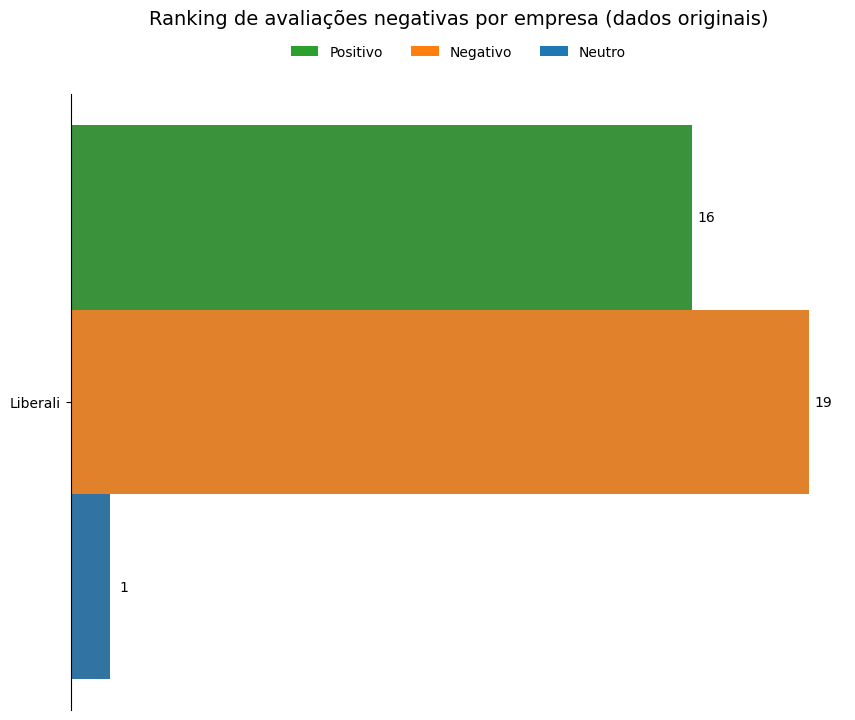

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 8))

sns.barplot(
    data=top_negative_companies_df,
    x="sentiment_count",
    y="company",
    hue="sentiment_plot",
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    ax=ax,
    width=0.9,
    orient="h",
)

# Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width(), (p.get_y() + p.get_height() / 2)),
        ha="center",
        va="center",
        fontsize=10,
        color="black",
        xytext=(10, 0),
        textcoords="offset points",
    )

# Axes config
ax.set_xlabel("")

ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Ranking de avaliações negativas por empresa (dados originais)",
    fontsize=ReportConfig.CHART_TITLE_FONT_SIZE,
    y=1.1,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

positive_patch = plt.Rectangle(
    (0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR
)
negative_patch = plt.Rectangle(
    (0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR
)
neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

ax.legend(
    # title="Sentimento",
    handles=[positive_patch, negative_patch, neutral_patch],
    labels=ReportConfig.PLOT_SENTIMENT_LABELS,
    bbox_to_anchor=(0.5, 1.1),
    loc="upper center",
    edgecolor="1",
    ncols=3,
)

plt.savefig(
    "real_negative_reviews_by_company.png",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Sentimento das avaliações ao longo do tempo

c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\venvs\venv_sent_analysis\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to p

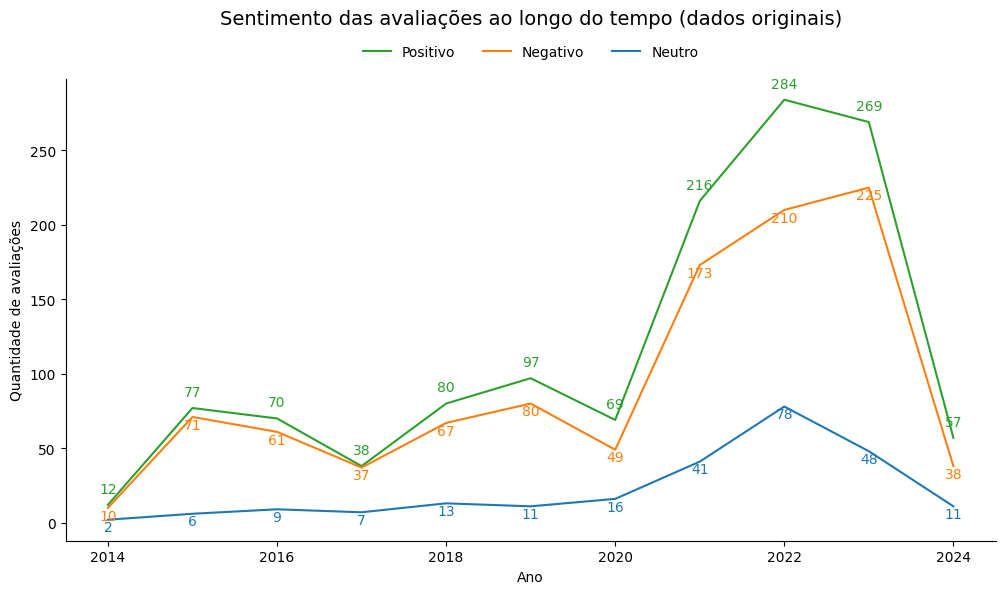

In [8]:
reviews_df["review_date"] = pd.to_datetime(
        reviews_df["review_date"], format="%Y-%m-%d"
    )
reviews_df["year"] = reviews_df["review_date"].dt.year

sentiment_counts = (
    reviews_df.groupby(["year", "sentiment"])
    .size()
    .reset_index(name="count")
)

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(
    data=sentiment_counts,
    x="year",
    y="count",
    hue="sentiment",
    palette=ReportConfig.SENTIMENT_PALETTE,
    ax=ax,
)

# Annotations for number of reviews per sentiment
years_unique = sentiment_counts["year"].unique()
for year in years_unique:
    year_counts = sentiment_counts[sentiment_counts["year"] == year][
        "count"
    ].tolist()

    neutral_counts, positive_counts, negative_counts = (year_counts + [None] * 3)[
        :3
    ]

    if neutral_counts:
        ax.text(
            x=year,
            y=neutral_counts - 8,
            s=f"{neutral_counts}",
            ha="center",
            color=ReportConfig.NEUTRAL_SENTIMENT_COLOR,
        )

    if positive_counts:
        ax.text(
            x=year,
            y=positive_counts + 8,
            s=f"{positive_counts}",
            ha="center",
            color=ReportConfig.POSITIVE_SENTIMENT_COLOR,
        )

    if negative_counts:
        ax.text(
            x=year,
            y=negative_counts - 8,
            s=f"{negative_counts}",
            ha="center",
            color=ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade de avaliações")

ax.set_title(
    "Sentimento das avaliações ao longo do tempo (dados originais)",
    fontsize=ReportConfig.CHART_TITLE_FONT_SIZE,
    y=1.1,
)

handles, labels = ax.get_legend_handles_labels()
order_map = {label: handle for handle, label in zip(handles, labels)}
handles = [order_map[sentiment] for sentiment in ReportConfig.PLOT_SENTIMENT_VALUES]

plt.legend(
    # title="Sentimento",
    handles=handles,
    labels=ReportConfig.PLOT_SENTIMENT_LABELS,
    bbox_to_anchor=(0.5, 1.1),
    loc="upper center",
    edgecolor="1",
    ncols=3,
)

plt.savefig(
    "real_sentiments_reviews_along_time.png",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Distribuição de sentimentos por quantidade de estrelas

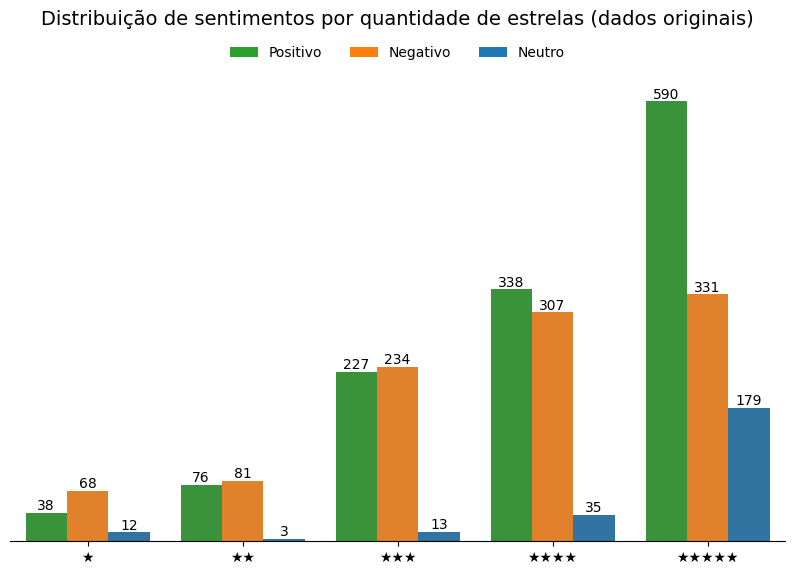

In [9]:
filtered_df = reviews_df[
    [
        "company",
        "employee_role",
        "employee_detail",
        "review_text",
        "review_date",
        "star_rating",
        "sentiment_plot",
        "sentiment_label",
    ]
]

filtered_df.reset_index(drop=True, inplace=True)

if len(filtered_df) > 0:
    sentiment_counts = (
        filtered_df.groupby(["star_rating", "sentiment_plot"])
        .size()
        .reset_index(name="count")
    )

    fig, ax = plt.subplots(1, figsize=(10, 6))

    bars = sns.barplot(
        data=sentiment_counts,
        x="star_rating",
        y="count",
        hue="sentiment_plot",
        ax=ax,
        palette=[
            ReportConfig.POSITIVE_SENTIMENT_COLOR,
            ReportConfig.NEGATIVE_SENTIMENT_COLOR,
            ReportConfig.NEUTRAL_SENTIMENT_COLOR,
        ],
    )

    for p in bars.patches:
        height = p.get_height()
        if math.isnan(height):
            height = 0.0

        bars.annotate(
            text=f"{int(height)}",
            xy=(p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            fontsize=10,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

    ax.set_title(
        "Distribuição de sentimentos por quantidade de estrelas (dados originais)",
        fontsize=ReportConfig.CHART_TITLE_FONT_SIZE,
        y=1.1,
    )

    ax.set_xlabel("")
    ax.set_xticklabels(
        ["\u2605" * int(x) for x in sentiment_counts["star_rating"].unique()]
    )

    ax.set_yticks([])
    ax.set_ylabel("")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    positive_patch = plt.Rectangle(
        (0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR
    )
    negative_patch = plt.Rectangle(
        (0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR
    )
    neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

    ax.legend(
        # title="Sentimento",
        handles=[positive_patch, negative_patch, neutral_patch],
        labels=ReportConfig.PLOT_SENTIMENT_LABELS,
        bbox_to_anchor=(0.5, 1.1),
        loc="upper center",
        edgecolor="1",
        ncols=3,
    )

plt.savefig(
    "real_sentiment_by_rating_star.png",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Ranking geral de avaliações

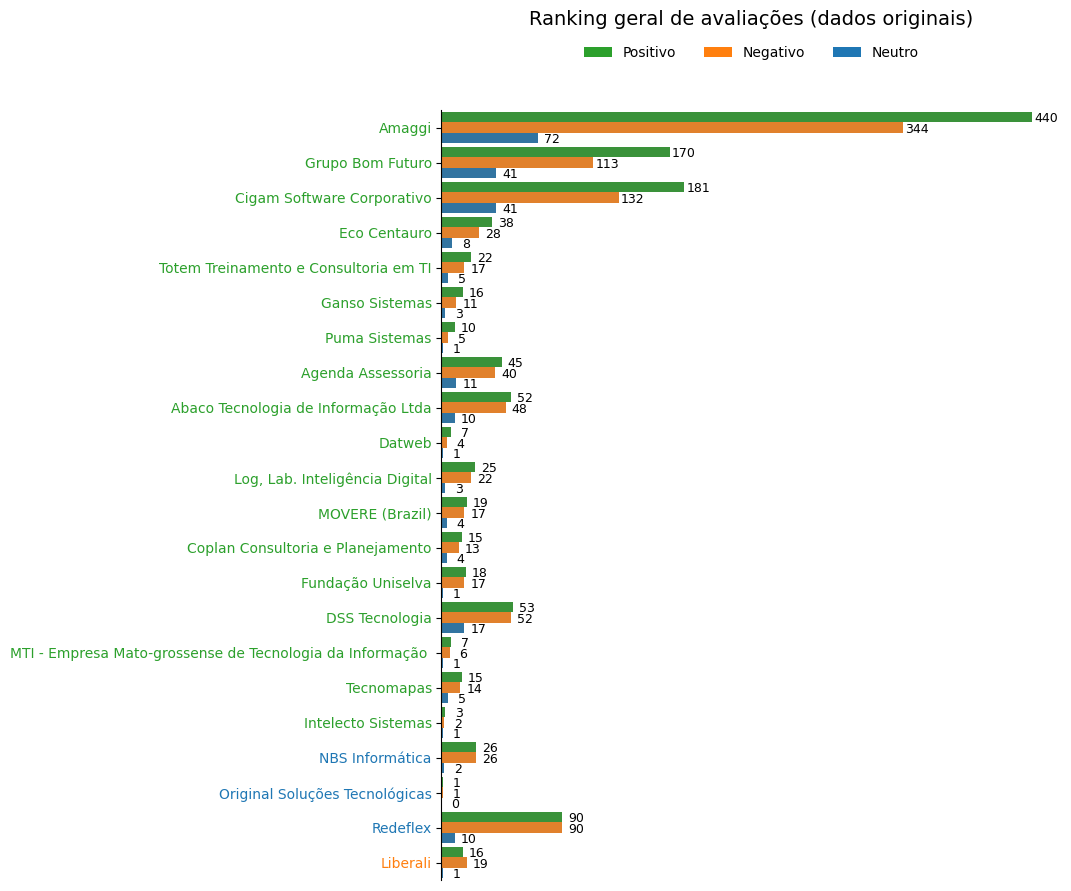

In [10]:
sentiment_plot_by_company_df = (
    reviews_df.groupby(["company", "sentiment_plot"]).size().unstack(fill_value=0)
)

sentiment_plot_by_company_df_reset = sentiment_plot_by_company_df.reset_index()
sentiment_plot_by_company_df_reset.columns = [
    "company",
    "1positive",
    "2negative",
    "3neutral",
]

sentiment_plot_by_company_df_reset["sentiment_diff"] = (
    sentiment_plot_by_company_df_reset["1positive"]
    - sentiment_plot_by_company_df_reset["2negative"]
)

bad_rating_companies = get_bad_rating_companies(sentiment_plot_by_company_df_reset)
good_rating_companies = get_good_rating_companies(sentiment_plot_by_company_df_reset)
neutral_rating_companies = get_neutral_rating_companies(
    sentiment_plot_by_company_df_reset
)

fig, ax = plt.subplots(1, figsize=(8, 10))

# Plot

sorted_companies_df = sentiment_plot_by_company_df_reset.sort_values(
    by="sentiment_diff", ascending=False
)["company"]

sns.countplot(
    data=reviews_df,
    y="company",
    hue="sentiment_plot",
    order=sorted_companies_df,
    ax=ax,
    palette=[
        ReportConfig.POSITIVE_SENTIMENT_COLOR,
        ReportConfig.NEGATIVE_SENTIMENT_COLOR,
        ReportConfig.NEUTRAL_SENTIMENT_COLOR,
    ],
    width=0.9,
)

# Highlight Companies
for i, label in enumerate(ax.get_yticklabels()):
    company_name = label.get_text()
    if company_name in bad_rating_companies:
        label.set_color(ReportConfig.NEGATIVE_SENTIMENT_COLOR)

for i, label in enumerate(ax.get_yticklabels()):
    company_name = label.get_text()
    if company_name in good_rating_companies:
        label.set_color(ReportConfig.POSITIVE_SENTIMENT_COLOR)

for i, label in enumerate(ax.get_yticklabels()):
    company_name = label.get_text()
    if company_name in neutral_rating_companies:
        label.set_color(ReportConfig.NEUTRAL_SENTIMENT_COLOR)

# Plot Annotates
for p in ax.patches:
    ax.annotate(
        text=f"{p.get_width():.0f}",
        xy=(p.get_width(), (p.get_y() + p.get_height() / 2)),
        ha="center",
        va="center",
        fontsize=9,
        color="black",
        xytext=(10, -1),
        textcoords="offset points",
    )

sns.despine(bottom=True)

ax.set_xlabel("")
ax.set_xticks([])

ax.set_ylabel("")

ax.set_title(
    "Ranking geral de avaliações (dados originais)",
    fontsize=ReportConfig.CHART_TITLE_FONT_SIZE,
    y=1.1,
)

positive_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.POSITIVE_SENTIMENT_COLOR)
negative_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEGATIVE_SENTIMENT_COLOR)
neutral_patch = plt.Rectangle((0, 0), 1, 1, fc=ReportConfig.NEUTRAL_SENTIMENT_COLOR)

ax.legend(
    # title="Sentimento",
    handles=[positive_patch, negative_patch, neutral_patch],
    labels=["Positivo", "Negativo", "Neutro"],
    bbox_to_anchor=(0.5, 1.1),
    loc="upper center",
    edgecolor="1",
    ncols=3,
)

plt.savefig(
    "real_general_sentiment_reviews_rank.png",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)

plt.show()